In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [ ]:
import scanpy as sc
import numpy as np 
import torch
import yaml

In [ ]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data"

# Training config

In [7]:
# Read config yaml
with open("train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed!

{'cluster_label': 'Allen.class_label',
 'lambda_count': 0.001,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': 'None'}

# Dataset 0

## Data loading

In [5]:
adata_sc = sc.read_h5ad(data_path + "/counts100k_norm_wo_raw_light.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 100000 × 31053
    obs: 'nUMI', 'nGene', 'dataset', 'QC', 'cluster', 'Allen.cluster_id', 'Allen.cluster_label', 'Allen.cluster_color', 'Allen.class_label', 'Allen.subclass_label', 'comb.QC'
    var: 'gene_ids', 'feature_types'

In [6]:
adata_st = sc.read_h5ad(data_path + "/slice200_norm_with_spatial.h5ad")
adata_st

AnnData object with n_obs × n_vars = 2155 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'is_sequential', 'is_combinatorial'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Train/Val genes split

In [8]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

202 training genes:  ['pcdh8' 'syt10' 'slc17a6' 'igfbp4' 'sema3e' 'enpp6' 'epha7' 'sncg' 'pld5'
 'alk'] ...
51 validation genes:  ['grik1' 'ankfn1' 'aqp4' 'adam2' 'plcxd3' 'mrgprx2' 'nxph2' 'grin3a'
 'bdnf' 'lama3'] ...


## Model training

In [9]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 172 M  | n/a  
---------------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.377   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([80799, 51])
G matrix shape: torch.Size([2133, 51])

Validation 0: {'val_score': 0.38459739089012146, 'val_sparsity-weighted_score': 0.009710395708680153, 'val_AUC': 0.473101943731308, 'val_entropy': 0.9348850846290588}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 201 genes
S matrix shape: torch.Size([80799, 201])
G matrix shape: torch.Size([2133, 201])


Trainig:   0%|          | 1/1000 [00:24<6:45:29, 24.35s/it]

Epoch 0: {'loss': -3.2533926963806152, 'main_loss': 0.34562984108924866, 'vg_reg': 0.3840920031070709, 'kl_reg': 1.1205906425004741e-08, 'entropy_reg': -0.0005790185532532632, 'l1_term': 1.375221785337999e-07, 'l2_term': 1.7236176375057255e-10, 'sparsity_term': 0.430510938167572, 'neighborhood_term': 0.5061972141265869, 'getis_ord_term': 0.5952000021934509, 'moran_term': -0.0006338753737509251, 'geary_term': 0.992975652217865, 'ct_island_term': 0.0}


Trainig:   5%|▍         | 49/1000 [19:40<6:22:11, 24.11s/it]Metric val_score improved. New best score: 0.530
Epoch 49, global step 50: 'val_score' reached 0.52955 (best 0.52955), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=49-val_score=0.530.ckpt' as top 3



Validation 49: {'val_score': 0.5295488834381104, 'val_sparsity-weighted_score': 0.012301637791097164, 'val_AUC': 0.601956307888031, 'val_entropy': 0.7696294188499451}


Trainig:  10%|▉         | 99/1000 [39:59<6:07:26, 24.47s/it]Metric val_score improved by 0.063 >= min_delta = 0.001. New best score: 0.593
Epoch 99, global step 100: 'val_score' reached 0.59290 (best 0.59290), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=99-val_score=0.593.ckpt' as top 3



Validation 99: {'val_score': 0.5928996801376343, 'val_sparsity-weighted_score': 0.01348287332803011, 'val_AUC': 0.6604167819023132, 'val_entropy': 0.2504705786705017}


Trainig:  10%|█         | 101/1000 [40:55<6:28:38, 25.94s/it]

Epoch 100: {'loss': -5.64488410949707, 'main_loss': 0.7987138628959656, 'vg_reg': 0.5983319282531738, 'kl_reg': 7.849276880733669e-05, 'entropy_reg': -0.00015512830577790737, 'l1_term': 1.614460103382953e-07, 'l2_term': 2.630667073066917e-10, 'sparsity_term': 0.8155962228775024, 'neighborhood_term': 0.8362909555435181, 'getis_ord_term': 0.8632261157035828, 'moran_term': 0.7349119186401367, 'geary_term': 0.998554527759552, 'ct_island_term': 0.000508034776430577, 'lr': 0.10000000149011612, 'val_score': 0.5928996801376343, 'val_sparsity-weighted_score': 0.01348287332803011, 'val_AUC': 0.6604167819023132, 'val_entropy': 0.2504705786705017}


Trainig:  15%|█▍        | 149/1000 [1:00:16<5:43:16, 24.20s/it]Metric val_score improved by 0.002 >= min_delta = 0.001. New best score: 0.595
Epoch 149, global step 150: 'val_score' reached 0.59523 (best 0.59523), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=149-val_score=0.595.ckpt' as top 3



Validation 149: {'val_score': 0.5952320694923401, 'val_sparsity-weighted_score': 0.013548843562602997, 'val_AUC': 0.6720649600028992, 'val_entropy': 0.12421279400587082}


Trainig:  20%|█▉        | 199/1000 [1:20:33<5:22:12, 24.14s/it]Metric val_score improved by 0.002 >= min_delta = 0.001. New best score: 0.597
Epoch 199, global step 200: 'val_score' reached 0.59674 (best 0.59674), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=199-val_score=0.597.ckpt' as top 3



Validation 199: {'val_score': 0.596741259098053, 'val_sparsity-weighted_score': 0.013574251905083656, 'val_AUC': 0.6753219366073608, 'val_entropy': 0.09418999403715134}


Trainig:  20%|██        | 201/1000 [1:21:28<5:40:59, 25.61s/it]

Epoch 200: {'loss': -5.786669731140137, 'main_loss': 0.8250412940979004, 'vg_reg': 0.6254152655601501, 'kl_reg': 9.35552452574484e-05, 'entropy_reg': -5.8336318033980206e-05, 'l1_term': 1.6276747771826194e-07, 'l2_term': 2.718486269426279e-10, 'sparsity_term': 0.8393843173980713, 'neighborhood_term': 0.8581681251525879, 'getis_ord_term': 0.8823767304420471, 'moran_term': 0.7578496932983398, 'geary_term': 0.9987373352050781, 'ct_island_term': 0.0001509530411567539, 'lr': 0.10000000149011612, 'val_score': 0.596741259098053, 'val_sparsity-weighted_score': 0.013574251905083656, 'val_AUC': 0.6753219366073608, 'val_entropy': 0.09418999403715134}


Trainig:  25%|██▍       | 249/1000 [1:40:55<5:05:21, 24.40s/it]Metric val_score improved by 0.001 >= min_delta = 0.001. New best score: 0.598
Epoch 249, global step 250: 'val_score' reached 0.59784 (best 0.59784), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=249-val_score=0.598.ckpt' as top 3



Validation 249: {'val_score': 0.597836971282959, 'val_sparsity-weighted_score': 0.013589364476501942, 'val_AUC': 0.6785173416137695, 'val_entropy': 0.08048632740974426}


Trainig:  30%|██▉       | 299/1000 [2:01:22<4:45:54, 24.47s/it]Monitored metric val_score did not improve in the last 1 records. Best score: 0.598. Signaling Trainer to stop.
Epoch 299, global step 300: 'val_score' reached 0.59816 (best 0.59816), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=299-val_score=0.598.ckpt' as top 3



Validation 299: {'val_score': 0.5981621146202087, 'val_sparsity-weighted_score': 0.013598932884633541, 'val_AUC': 0.6800968050956726, 'val_entropy': 0.07255382090806961}


Trainig:  30%|███       | 300/1000 [2:01:54<4:44:26, 24.38s/it]


## Loss Landscape

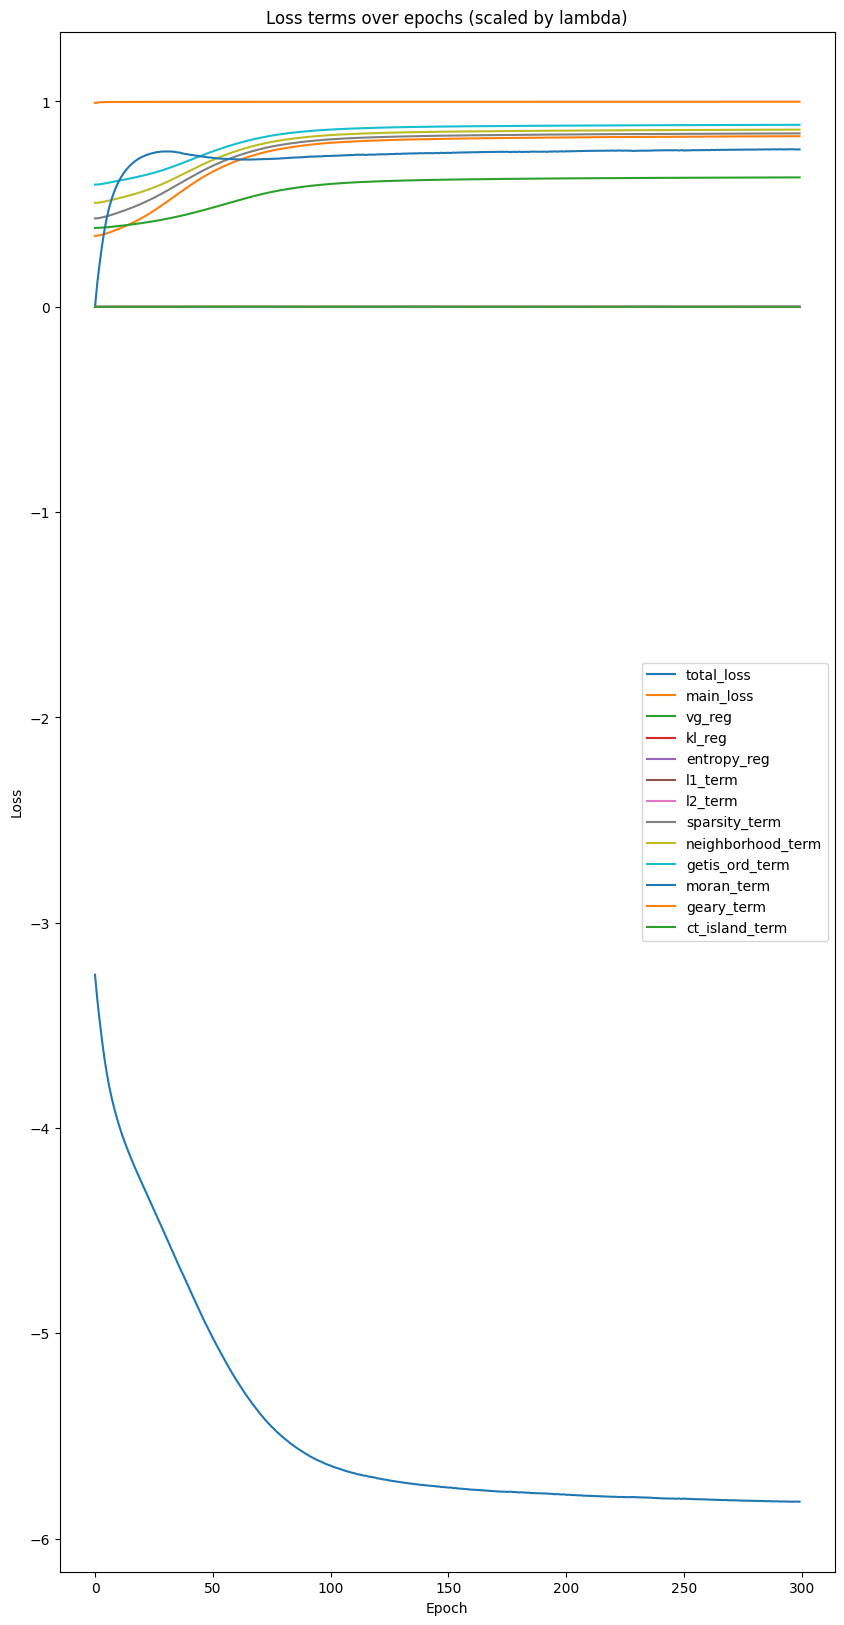

In [10]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True)

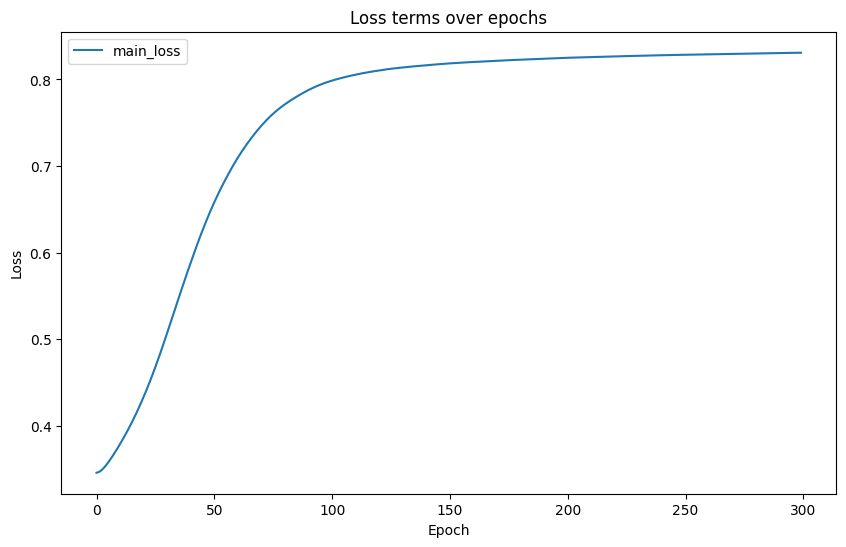

In [11]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map, loss_key="main_loss", lambda_scale=False)

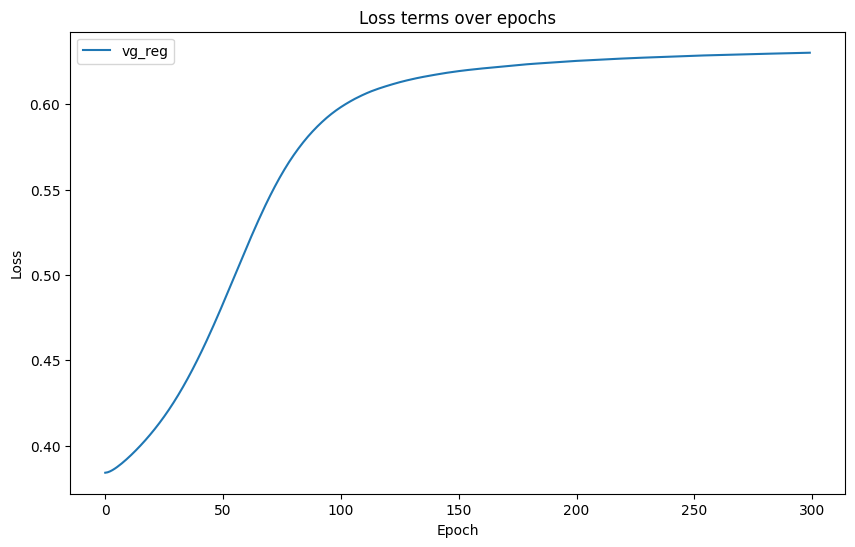

In [12]:
# Plot voxels/genes term
tgl.plot_loss_term(adata_map=ad_map, loss_key="vg_reg", lambda_scale=False)

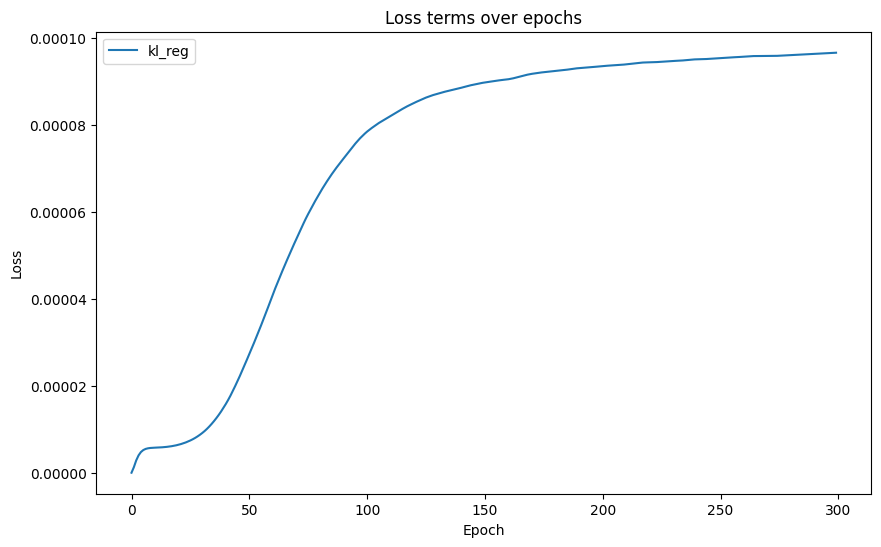

In [13]:
# Plot KL term
tgl.plot_loss_term(adata_map=ad_map, loss_key="kl_reg", lambda_scale=False)

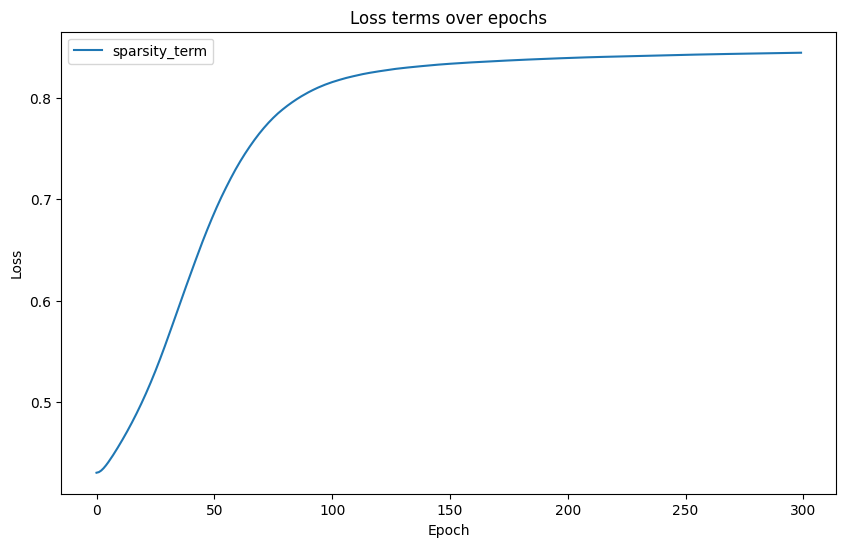

In [19]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="sparsity_term", lambda_scale=False)

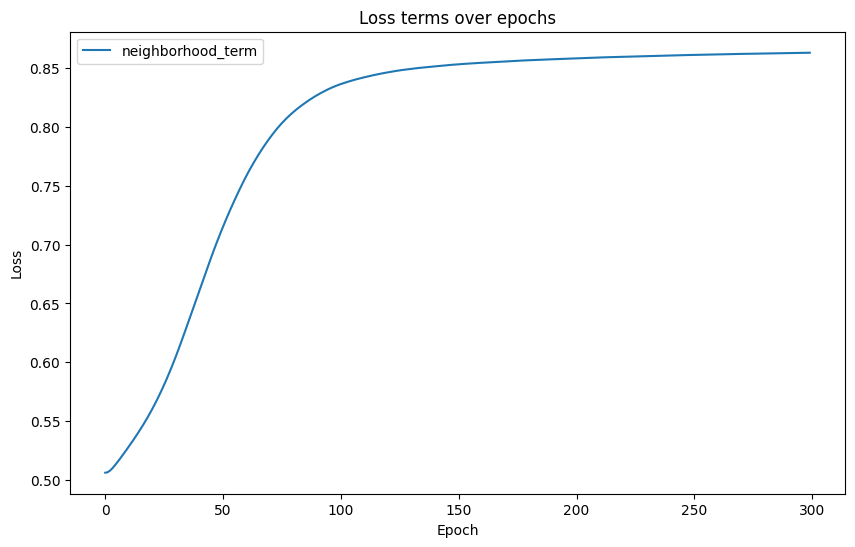

In [20]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="neighborhood_term", lambda_scale=False)

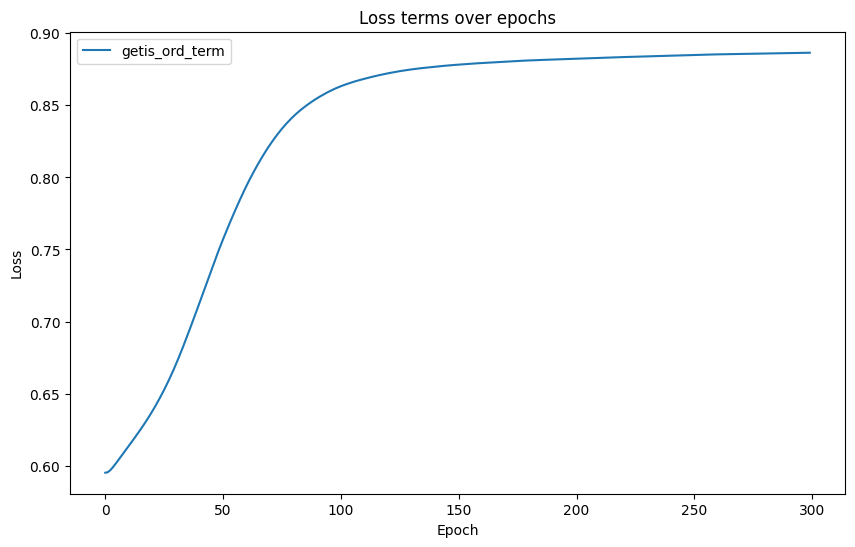

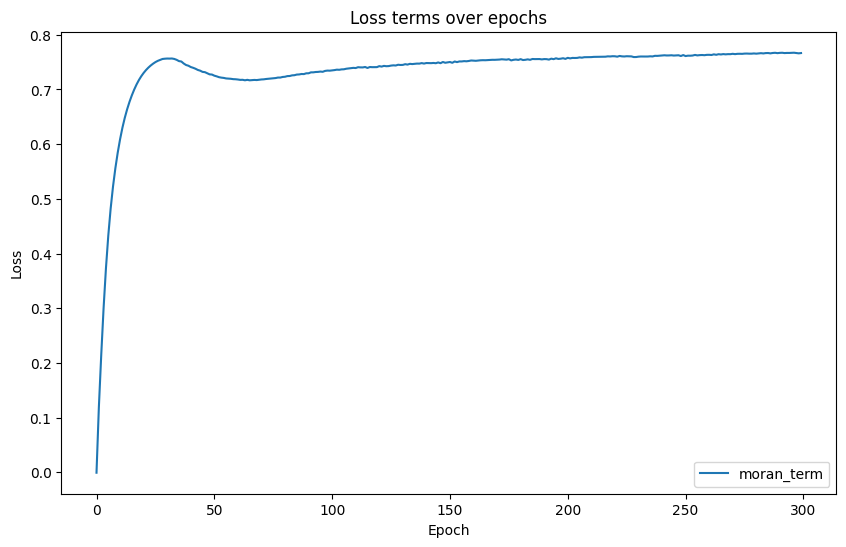

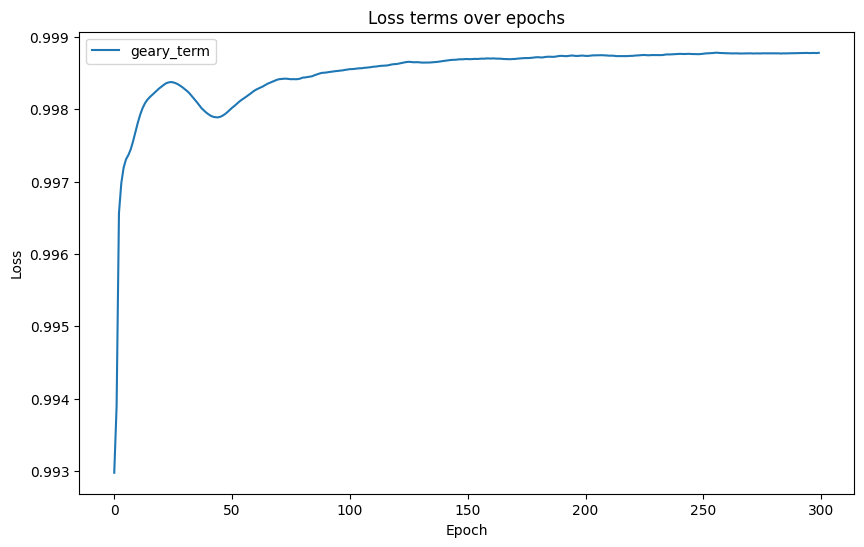

In [24]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="getis_ord_term", lambda_scale=False)
tgl.plot_loss_term(adata_map=ad_map, loss_key="moran_term", lambda_scale=False)
tgl.plot_loss_term(adata_map=ad_map, loss_key="geary_term", lambda_scale=False)

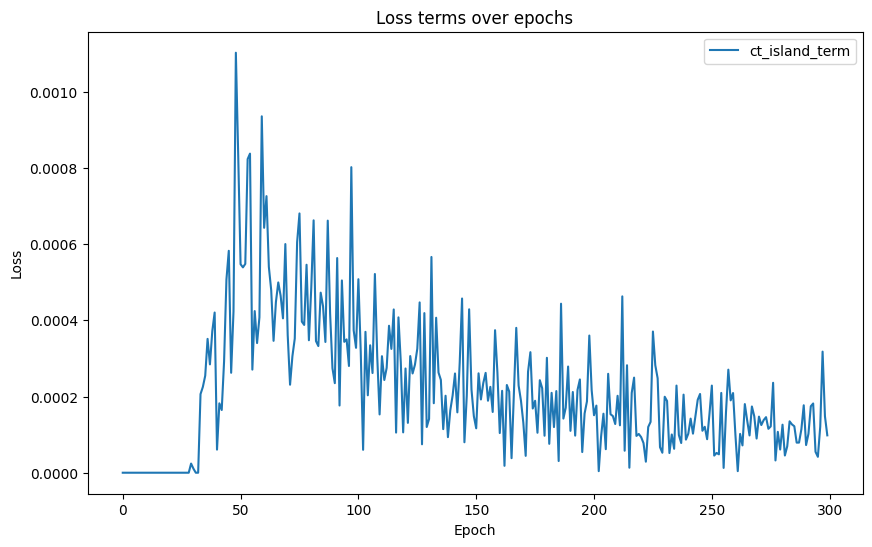

In [16]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


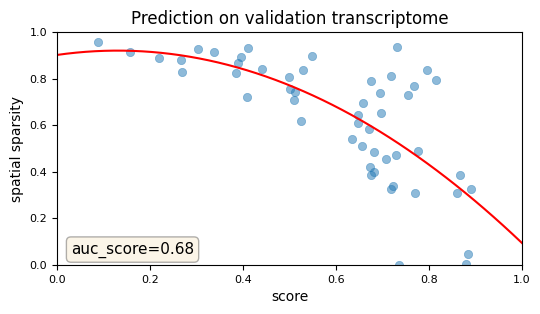

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.6800968050956726      │
│           val_JS            │     0.2866094708442688      │
│           val_PCC           │     0.5013231635093689      │
│          val_RMSE           │     0.9738678336143494      │
│          val_SSIM           │     0.33791083097457886     │
│         val_entropy         │     0.07255382090806961     │
│          val_score          │     0.5981621146202087      │
│ val_sparsity-weighted_score │    0.013598932884633541     │
└─────────────────────────────┴─────────────────────────────┘

In [38]:
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

## Sparsity Analysis

In [ ]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

In [ ]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

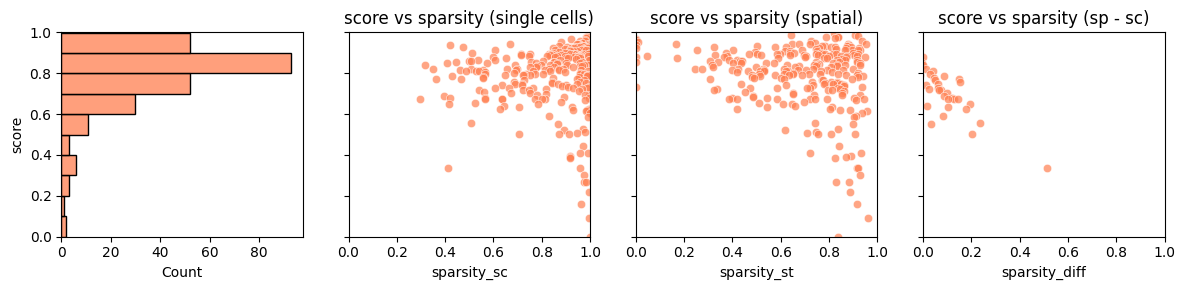

In [ ]:
# Plot training scores panels
tgl.plot_training_scores(df)

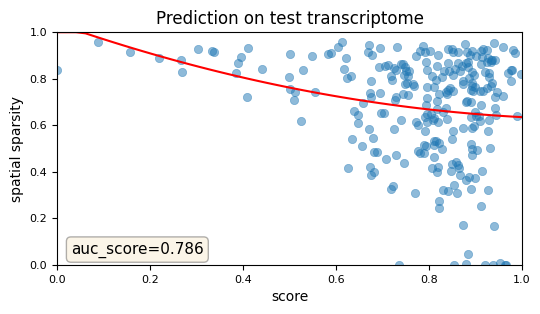

In [ ]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)

## Save results

In [ ]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_0', adata=ad_map, ext='h5ad')

## Reload model from ckpt

In [ ]:
# Check state dict
mapper.state_dict().keys()

odict_keys(['M', 'ct_encode', 'voxel_weights', 'neighborhood_filter', 'spatial_weights_morangeary', 'spatial_weights_getisord'])

In [ ]:
# Load checkpoint
ckpt = torch.load("checkpoints/last.ckpt", map_location="cpu")  # last
ckpt['state_dict'].keys()


In [ ]:
from tangramlit import MapperLightning as ML

# Load into mapper
model_reload = ML.load_from_checkpoint(ckpt)
